# Deriving $f_{CDA}$ Using Z-Fit & Upstream XGB

In [1]:
import numpy as np
import tensorflow as tf
import zfit
from zfit import z
import pandas as pd
import uproot as up
import hist
from hist import Hist
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)

/Users/chandler/miniconda/envs/tf/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [13]:
obs = zfit.Space('x', -10, 10) # Defines the name and domain of the observable
mu = zfit.Parameter("mu", 2.4, -1, 5) # Parameter name, default value, lower and upper limits
sigma = zfit.Parameter("sigma", 1.3, 0, 5)
yield_model = zfit.Parameter('yield_model', 5000, 1, 10000)

In [14]:
# gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma) # Define your PDF
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, extended=yield_model)  # Extended i.e unnormalized

In [15]:
data_np = np.random.normal(0, 1, size=10000)
data = zfit.Data(data_np, obs=obs)

In [16]:
# Step 1: create an unbinned likelihood with the given PDF and data
#nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)
nll = zfit.loss.ExtendedUnbinnedNLL(model=gauss, data=data)

# Step 2: instantiate a minimiser (in this case a basic minuit minimizer)
minimizer = zfit.minimize.Minuit()

# Step 3: minimise the given negative likelihood
result = minimizer.minimize(nll)

In [17]:
param_hesse = result.hesse()
print(param_hesse)

{<zfit.Parameter 'yield_model' floating=True value=9997>: {'error': 81.14646493138605, 'cl': 0.68268949}, <zfit.Parameter 'mu' floating=True value=0.002839>: {'error': 0.0099639237728642, 'cl': 0.68268949}, <zfit.Parameter 'sigma' floating=True value=0.9964>: {'error': 0.007045669493109619, 'cl': 0.68268949}}


In [18]:
# Check the fit cnverged and is valid
print(f"Function minimum: {result.fmin}")
print(f"Converged: {result.converged}")
print(f"Valid: {result.valid}")

Function minimum: -67949.93155138814
Converged: True
Valid: True


In [19]:
print(result.params)
print(result.params['mu']['value'])

name           value  (rounded)        hesse    at limit
-----------  ------------------  -----------  ----------
yield_model             9997.22  +/-      81       False
mu                   0.00283861  +/-    0.01       False
sigma                  0.996412  +/-   0.007       False
0.002838608646122287


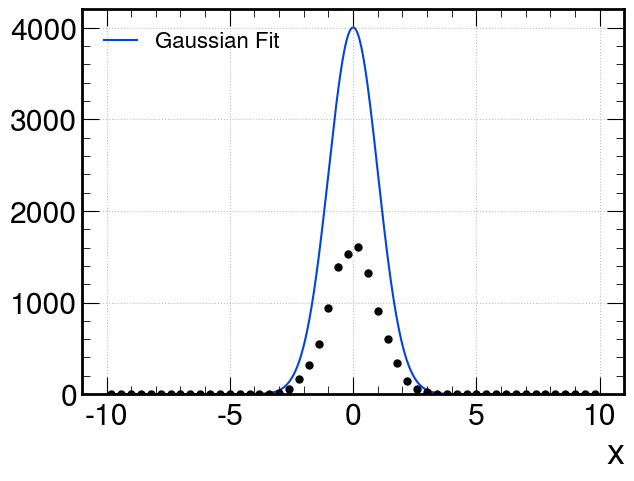

In [20]:
# plot the data as a histogramm
bins = 50
plt.figure(figsize=(7,5))
hep.histplot(data.to_binned(bins), yerr=True, density=False, color='black', histtype='errorbar')
# evaluate the func at multiple x and plot
x_plot = np.linspace(obs.v1.lower, obs.v1.upper, num=1000)
y_plot = gauss.ext_pdf(x_plot)
plt.plot(x_plot, y_plot, color='xkcd:blue', label="Gaussian Fit")
plt.legend(loc="upper left", fontsize=16)
plt.grid()
plt.show()

yield_model is just telling us the estimate for the total number of events in the dataset.

## Example: Binned Data

In [2]:
# Artifically bin the data
data_np = np.random.normal(2.1, 1.0, size=10000)

h = hist.Hist(hist.axis.Regular(bins=50, start=-8, stop=10, name="x"))
h.fill(x=data_np)
#hep.histplot(h)

Hist(Regular(50, -8, 10, name='x'), storage=Double()) # Sum: 10000.0

In [3]:
# Step 4: Convert binned data to zfit format
data = zfit.data.BinnedData.from_hist(h)

In [4]:
# Step 2: Define observables and parameters
obs2 = zfit.Space('x', -10, 10, binning=zfit.binned.RegularBinning(50, -8, 10, name="x"))
mu2 = zfit.Parameter("mu", 0.0, -10, 10)
sigma2 = zfit.Parameter("sigma", 1.0, 0.1, 5)

In [5]:
# Step 3: Create Gaussian model
gauss = zfit.pdf.Gauss(obs=obs2, mu=mu2, sigma=sigma2)
gauss_binned = zfit.pdf.BinnedFromUnbinnedPDF(pdf=gauss, space=obs2)

In [7]:
# Step 5: Define the binned negative log likelihood
nll = zfit.loss.BinnedNLL(model=gauss, data=data)

# Step 6: Instantiate a minimizer
minimizer = zfit.minimize.Minuit()

# Step 7: Minimize the negative log likelihood
result = minimizer.minimize(nll)

In [8]:
def print_result(result):
    print(f"Function minimum: {result.fmin}")
    print(f"Converged: {result.converged}")
    print(f"Valid: {result.valid}")

print_result(result)

Function minimum: -57760.900476458424
Converged: True
Valid: True


In [9]:
print(result.params)

name      value  (rounded)    at limit
------  ------------------  ----------
mu                 2.10573       False
sigma             0.988324       False


In [19]:
gauss_unbinned = zfit.pdf.UnbinnedFromBinnedPDF(gauss, obs=obs2)

In [26]:
obs_continuous = zfit.Space('x', -10, 10)
plot_gaus = zfit.pdf.Gauss(obs=obs_continuous, mu=mu2, sigma=sigma2)

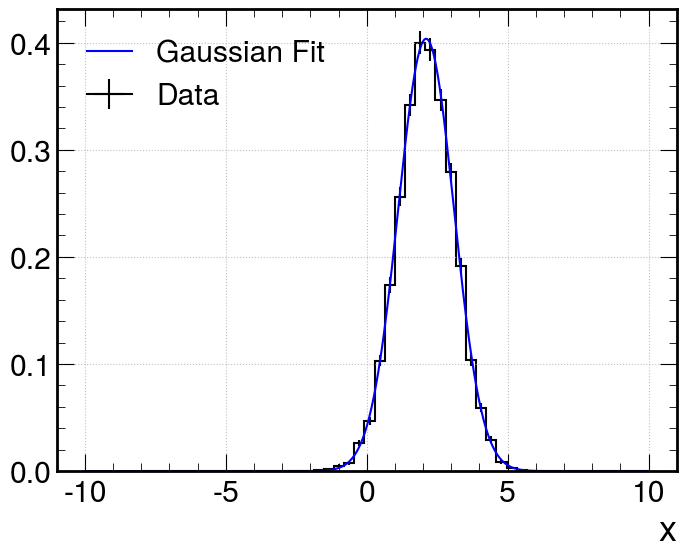

In [27]:
plt.figure(figsize=(8,6))
hep.histplot(h, label="Data", density=True, color="black")
x_plot = np.linspace(obs2.v1.lower, obs2.v1.upper, num=1000)
y_plot = plot_gaus.pdf(x_plot)
plt.plot(x_plot, y_plot, color="blue", label="Gaussian Fit")
plt.legend()
plt.grid()
plt.show()

## Custom Models

In [17]:
class SecondOrderPoly(zfit.pdf.ZPDF):
    """Second order polynomial `a + b * x + c * x^2`"""
    _PARAMS = ['b', 'c']  # specify which parameters to take

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):  # implement function, unnormalized
        data = x[0]  # axis 0
        b = params['b']
        c = params['c']

        return 1 + b * data + c * data ** 2

In [18]:
obs = zfit.Space("obs1", -4, 4)

b = zfit.Parameter('b', 0.2, 0.1, 10)
custom_poly = SecondOrderPoly(obs=obs, b=b, c=1.4)